# Nonlinear Least Squares demo: Navigation

Borrowed from L.Vandenberghe, UCLA, EE133A. Coded by Laurent Lessard in 2018; modified by Ruohui Wang in 2021.

In [1]:
using Pkg
Pkg.add("PyPlot")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


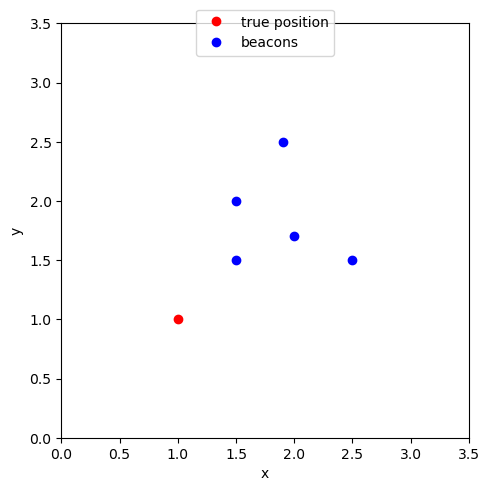

In [4]:
using Random

Random.seed!(236787)

locs = [ 1.5  1.5
         1.5  2.0
         1.9  2.5
         2.0  1.7
         2.5  1.5 ]

n = size(locs,1)

truepos = [ 1.0  1.0 ]

# generate measurements
# error because `dims` is a keyword argument, must be called with sum(xx, dims=y)
ymeas = sqrt.( sum( (locs - ones(n,1)*truepos).^2, dims=2) ) + 0.2*(rand(n) .- 0.5)  # can add noise

using PyPlot
figure(figsize=[5,5])
plot( truepos[1], truepos[2], "ro", label="true position" )
plot( locs[:,1], locs[:,2], "bo", label="beacons")
legend(numpoints=1,loc="upper center", bbox_to_anchor=(0.5, 1.05))
axis([0,3.5,0,3.5]); xlabel("x"); ylabel("y"); tight_layout();
#savefig("NLS_beacons.pdf")

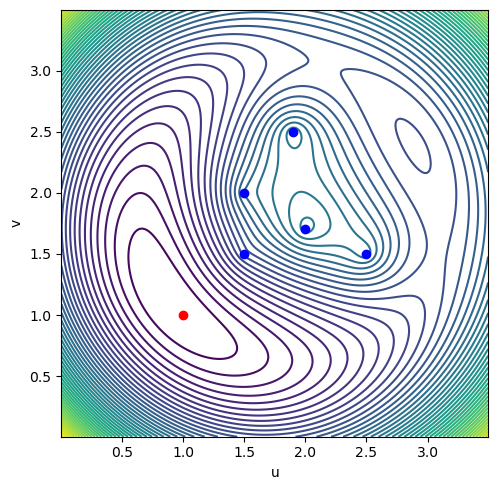

In [5]:
using PyPlot

xv=range(0,stop=3.5,length=351) 
yv=range(0,stop=3.5,length=351) 


# swap x and y to obtain standard coordinates
# same as above, specify dims=2
res = [ sum((sqrt.(sum((locs - ones(n,1)*[x y]).^2, dims=2)) - ymeas).^2) for y in yv, x in xv ];

pygui(false)
figure(figsize=(6,5))
contour( res, origin="lower", extent=(0,3.5,0,3.5), 60, )
plot( locs[:,1], locs[:,2], "bo" )
plot( truepos[1], truepos[2], "ro" )
axis("image"); xlabel("u"); ylabel("v")
#colorbar()
tight_layout();
#savefig("NLS_contour.pdf")

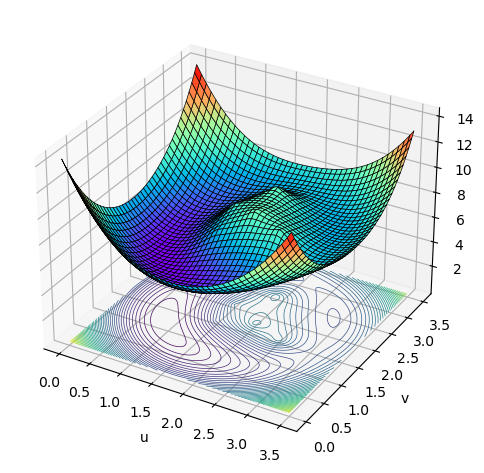

In [6]:
# error because of the grammar
function meshgrid(vx::AbstractVector{T}, vy::AbstractVector{T}) where {T}
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    # error because repmat is replaced by repeat
    (repeat(vx, m, 1), repeat(vy, 1, n))
end

(X,Y) = meshgrid(xv,yv);

pygui(false)
# cannot add int to float array, use .+
surf(X,Y, res .+ 5., rstride=8, cstride=8,cmap="rainbow",edgecolor="black", linewidths=.5)
contour(X, Y, res, zdir="z", 60, offset=0, origin="lower", linewidths=.5 )
xlabel("u"); ylabel("v");
tight_layout()
#savefig("NLS_surface.pdf")

In [7]:
# show in a pop-out window instead
pygui(true)
surf(X,Y, res .+ 5., rstride=8, cstride=8,cmap="rainbow")
contour(X, Y, res, zdir="z", 60, offset=0, origin="lower" )
xlabel("x"); ylabel("y");

## Solve using JuMP

In [5]:
using JuMP, Ipopt

m = Model(Ipopt.Optimizer)
@variable(m, x)
@variable(m, y)
@NLexpression(m, dist[i=1:5], sqrt( (locs[i,1]-x)^2 + (locs[i,2]-y)^2 ) ) 
@NLobjective(m, Min, sum( (dist[i] - ymeas[i])^2 for i=1:5 ) )


# depending on the start value, we can converge to different local minima
# e.g. (0,0) --> global minimum, (3,3) --> local minimum

set_start_value(x, 1.4)
set_start_value(y, 2.0)

optimize!(m)

println(value.([x y]))
println(objective_value(m))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c